In [2]:
import os
import pandas as pd
import keras
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
import tensorflow as tf
import splitfolders
import cv2
import random
import seaborn as sns


## Image Preprocessing

### Image Visualization
We started by exploring the dataset. All the images have different sizes, and some have varying orientations, which will require standardization work later on.


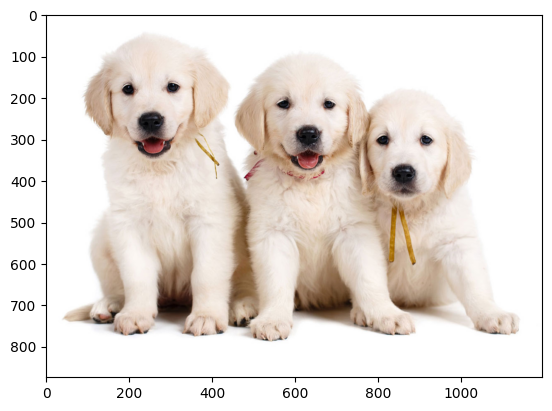

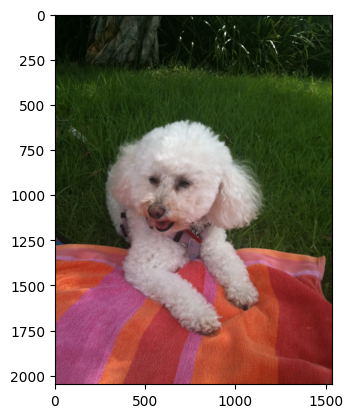

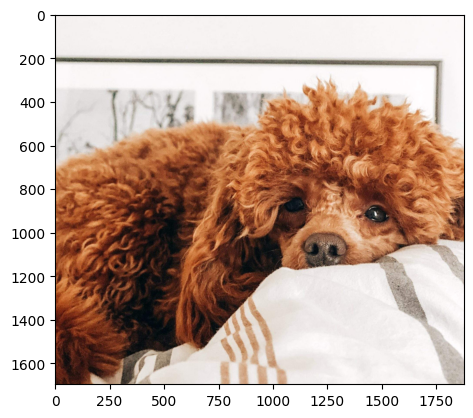

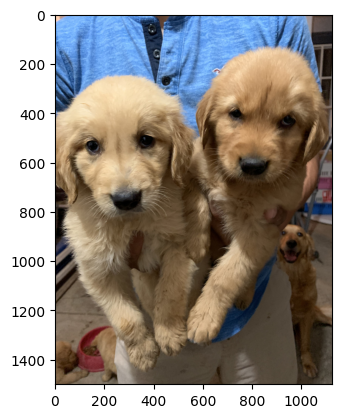

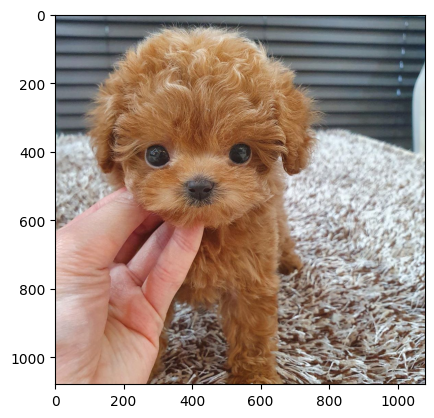

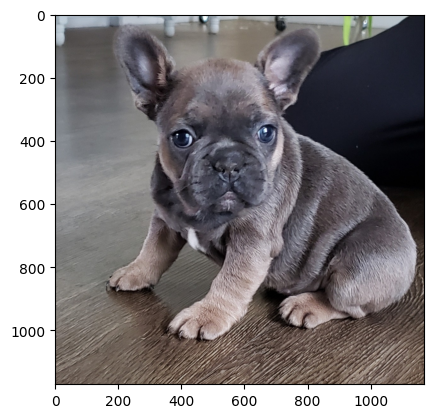

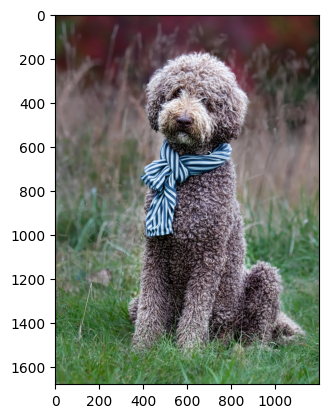

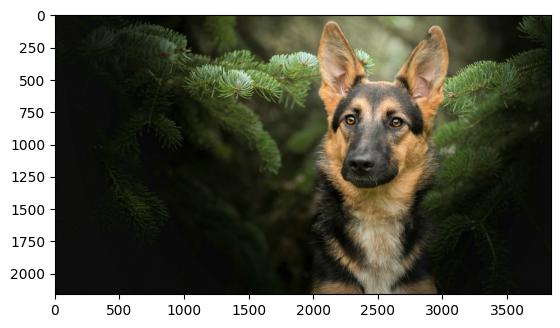

In [3]:

images=[]
dogs=[]
for razas in os.listdir('dogs'):
    direct=os.path.join('dogs',razas)
    for i in os.listdir(direct):
        perros2=os.path.join(direct,i)
        dogs.append(perros2)

random.shuffle(dogs)
for i in range(8):
    img_rgb = cv2.cvtColor(cv2.imread(dogs[i]), cv2.COLOR_BGR2RGB)
    plt.imshow(cv2.cvtColor((cv2.imread(dogs[i])),cv2.COLOR_BGR2RGB))
    plt.show()




### Creation of directories for training

In [4]:
#Creating the training test and validation directories
classes=['french_bulldog','german_shepherd','golden_retriever','poodle']
dataset_dir='dogs'
#Standard split of %80 %10 %10
splitfolders.ratio(dataset_dir, output="output", seed=1337, ratio=(0.8, 0.1,0.1), group_prefix=None) # default values


Copying files: 80 files [00:00, 105.27 files/s]


### Preprocessing

To make the model more robust, the training and validation images are distorted.
Note: the testing images are only normalized

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
test_data_gen = ImageDataGenerator(
                                    rescale=1./255)


### Synthetic images(optional)

If the model results were different, not only would the training images be distorted, but more images would be generated with the same distortions. This way, we would have more training images which, although not useful as entirely new images, would provide a larger dataset for the model to learn from.

### Definition of Training Directories

The training directories are defined. It is important to note that the target size for all is the same, and shuffle is set to true in the training process to introduce even more variability. Additionally, since we will visually check the testing images against the predictions, they are saved with `class_mode = none`, meaning the testing directory contains only scaled and normalized images.

In [8]:
Batch_size = 8
img_h = 256
img_w = 256
#We set the seed for reproducibility
SEED = 1234
tf.random.set_seed(SEED) 
training_dir = os.path.join('output', 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  
# Validation
valid_dir = os.path.join('output', 'val')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
test_dir = os.path.join('output', 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)


Found 64 images belonging to 4 classes.


Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


### TransferLearning

Due to the limited data we have, training a neural network from scratch would be counterproductive. For this purpose, a well-known network like ResNet152v12 will be imported, and additional layers with a softmax output of 4 classes will be added. This model will be trained on the constrained set of images we have.

Note: The preprocessing of the images could also be part of the model; however, in this implementation, the preprocessing is applied to the images directories.

In [7]:


#We import the ResNet152V2 model and perform transfer learning. Additionally, we add dense layers for the final classification and apply dropout to prevent overfitting.
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
     

from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
#The ResNet weights are fixed, and the network layers are frozen, except for the ones we added to fine-tune the model.

for layer in ResNet_model.layers[:-5]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(ResNet_model.input, output)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

### Definition of Loss Function, Optimizer, and Learning Rate Reducer

A standard measure like Crossentropy is used since this is a classification problem. The optimizer is ADAM to avoid local minima that may occur with more typical gradient descent as it takes into account the first and second order of momentum. The ReduceLROnPlateau function is applied to lower the learning rate if no improvement is seen in the val_accuracy for 3 epochs. The factor of 0.4 simply reduces this metric by that amount if no improvement occurs.

Note: Since we have so few validation cases, it is quite debatable whether the ReduceLROnPlateau function contributed to reaching the global optimum of the problem.

In [26]:
#Defining the loss function and optimizer
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#We add the methods to calculate more metrics
precision = tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
auc=tf.keras.metrics.AUC()

model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy',precision,recall,auc],run_eagerly=True)

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#The learning rate is reduced if accuracy does not improve within 3 epochs.
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

## Model training

In [27]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
#Training the model
transfer_learning_history = model.fit(train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=20,
                  callbacks=callbacks,verbose=1
                  
                    
)


Epoch 1/20
8/8 [==============================] - 101s 11s/step - loss: 0.5514 - accuracy: 0.8438 - precision_4: 0.8413 - recall_4: 0.8281 - auc_2: 0.9753 - val_loss: 3.4324 - val_accuracy: 0.6250 - val_precision_4: 0.6250 - val_recall_4: 0.6250 - val_auc_2: 0.7526 - lr: 0.0010
Epoch 2/20
8/8 [==============================] - 67s 8s/step - loss: 0.0613 - accuracy: 0.9844 - precision_4: 0.9841 - recall_4: 0.9688 - auc_2: 0.9994 - val_loss: 5.2291 - val_accuracy: 0.6250 - val_precision_4: 0.6250 - val_recall_4: 0.6250 - val_auc_2: 0.8568 - lr: 0.0010
Epoch 3/20
8/8 [==============================] - 67s 8s/step - loss: 0.1468 - accuracy: 0.9688 - precision_4: 0.9688 - recall_4: 0.9688 - auc_2: 0.9954 - val_loss: 0.3152 - val_accuracy: 0.8750 - val_precision_4: 0.8750 - val_recall_4: 0.8750 - val_auc_2: 0.9740 - lr: 0.0010
Epoch 4/20
8/8 [==============================] - 67s 8s/step - loss: 0.1222 - accuracy: 0.9688 - precision_4: 0.9688 - recall_4: 0.9688 - auc_2: 0.9984 - val_loss: 2.

Due to playback speed issues, locally I decided to save this final model and reload it

In [10]:

#model.save('ultimomodelov2.h5')
#model.save('modelo0604.h5')
#model=keras.models.load_model('ultimomodelov2.h5')

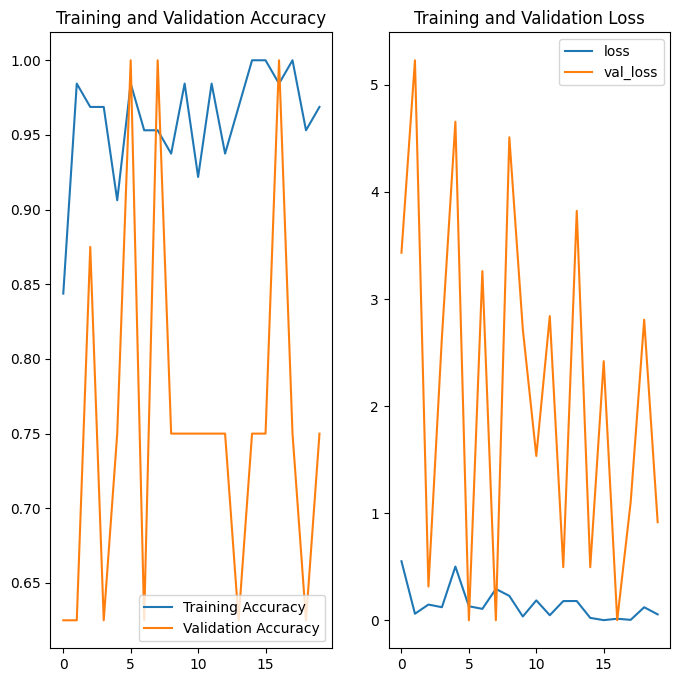

In [52]:
#Accuracy and loss through the epochs
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']


loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='loss')
plt.plot(epochs_range, val_loss, label='val_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





As a sanity check, we evaluate the model on the validation set, keeping in mind that it was intentionally distorted and consists of 8 distorted images. An accuracy of 0.75 seems reasonable. We altered the validation data set on purpouse so it is to be expected a lower accuracy

In [66]:
valid_gen.reset()
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)
y=model.predict(valid_gen,steps=STEP_SIZE_VALID,verbose=1)
y_pred = np.argmax(y, axis=1)
y_true = valid_gen.classes
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))


1/1 [==============================] - 3s 3s/step
                  precision    recall  f1-score   support

  french_bulldog       0.67      1.00      0.80         2
 german_shepherd       1.00      1.00      1.00         2
golden_retriever       1.00      0.50      0.67         2
          poodle       0.50      0.50      0.50         2

        accuracy                           0.75         8
       macro avg       0.79      0.75      0.74         8
    weighted avg       0.79      0.75      0.74         8



We proceed to test the test_data_set obtaining amazing results. Keep in mind that the testing dasta sufferd no alterations whatsoever besides the preprocessing

1/1 [==============================] - 3s 3s/step
                  precision    recall  f1-score   support

  french_bulldog       1.00      1.00      1.00         2
 german_shepherd       1.00      1.00      1.00         2
golden_retriever       1.00      1.00      1.00         2
          poodle       1.00      1.00      1.00         2

        accuracy                           1.00         8
       macro avg       1.00      1.00      1.00         8
    weighted avg       1.00      1.00      1.00         8



<Axes: >

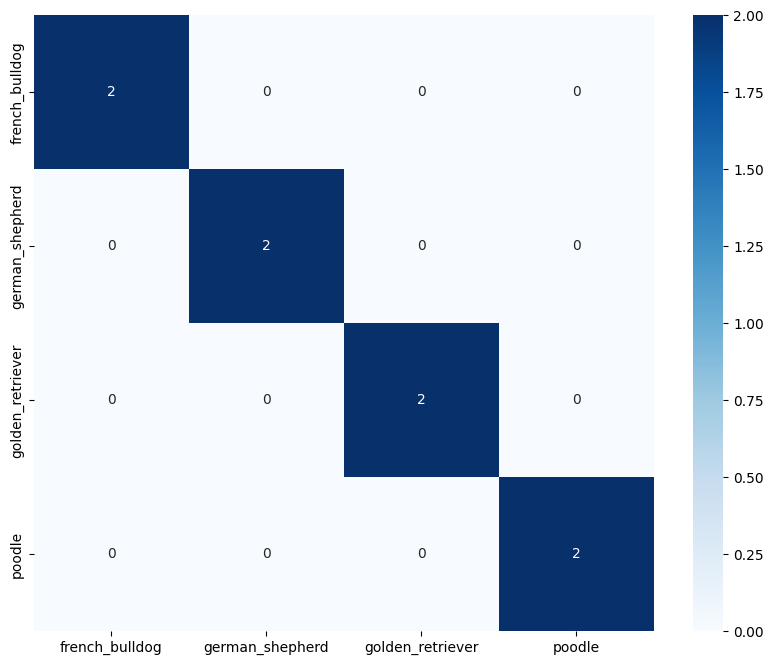

In [67]:
test_gen.reset()
STEP_SIZE_TRAIN=test_gen.n//train_gen.batch_size
model.evaluate(test_gen, steps=STEP_SIZE_VALID,verbose=1)
y=model.predict(test_gen,steps=STEP_SIZE_VALID,verbose=1)
y_pred = np.argmax(y, axis=1)
y_true = test_gen.classes
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=classes,yticklabels=classes)

### Testing

The 8 undistorted images we saved for testing were classified perfectly. (Although I have doubts about whether the poodle is indeed a poodle.)

1/1 [==============================] - 3s 3s/step


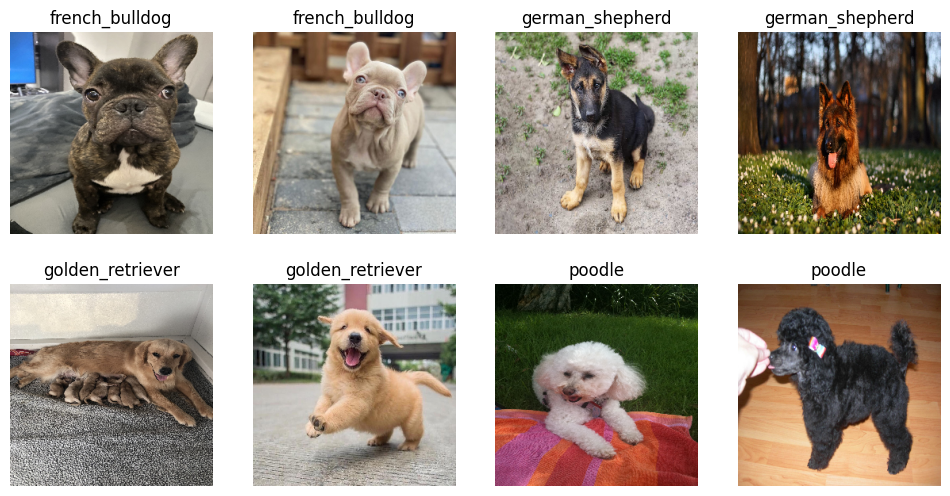

In [61]:
test_gen.reset()
labels = test_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
pred=model.predict(test_gen,
steps=1,
verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i in range(8):
    img = test_gen[0][0][i]
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(predictions[i])



## Handling the "Other" Class


### Alternative 1: Define a Threshold for "Trusting" the Classification

Images of borderline cases (at least from a human perspective) were evaluated. Based on this, the best prediction from the softmax layer is compared with this threshold. If the softmax score is below the threshold, the image is classified as "other"; otherwise, it is processed normally. This way, predictions where our model is not very confident about the classification are labeled as "other."

In [13]:
def classifyimg(path,threshold):
    path=os.path.join('Pruebas', path)
    img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    predictions=np.argmax(pred,axis=1)
    trust=np.max(pred)
    if trust< threshold:
        predictions2='other'
    else:
        predictions2 = [labels[k] for k in predictions]
    plt.show()
    plt.imshow(img)
    plt.title(str(predictions2) + ' ' +str(trust))
        
    return pred, trust

1/1 [==============================] - 0s 324ms/step


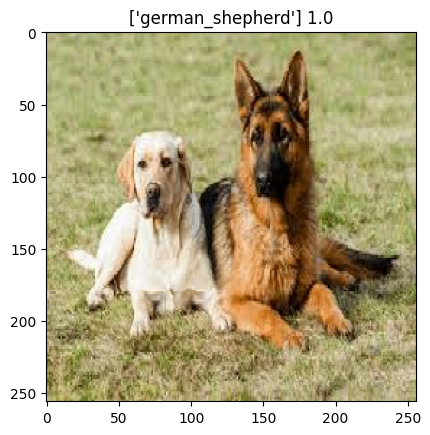

1/1 [==============================] - 0s 312ms/step


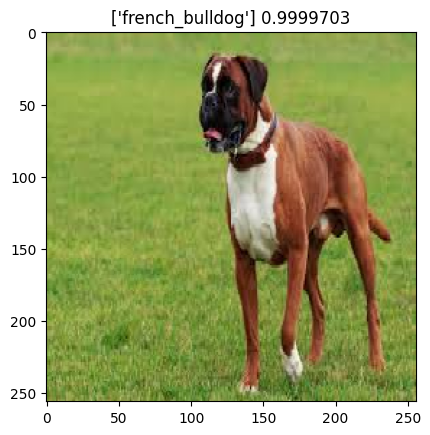

1/1 [==============================] - 0s 320ms/step


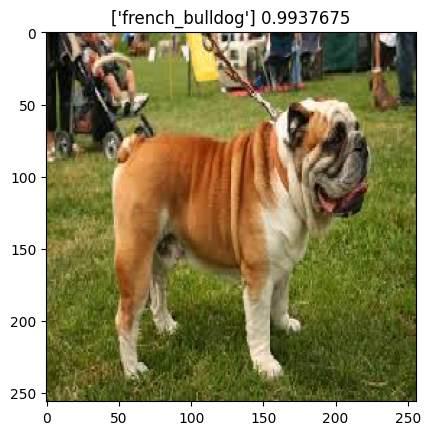

1/1 [==============================] - 0s 298ms/step


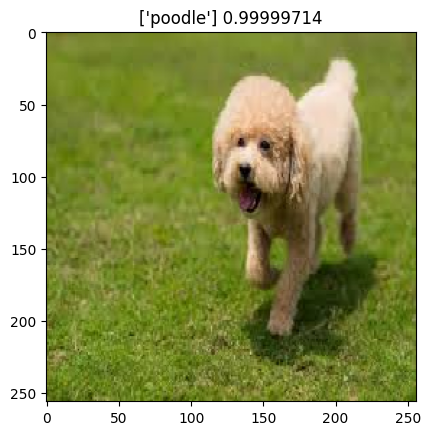

1/1 [==============================] - 0s 311ms/step


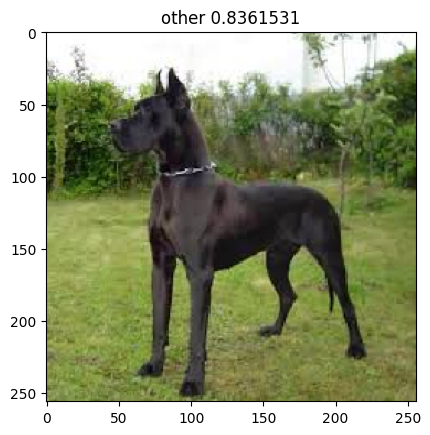

1/1 [==============================] - 0s 314ms/step


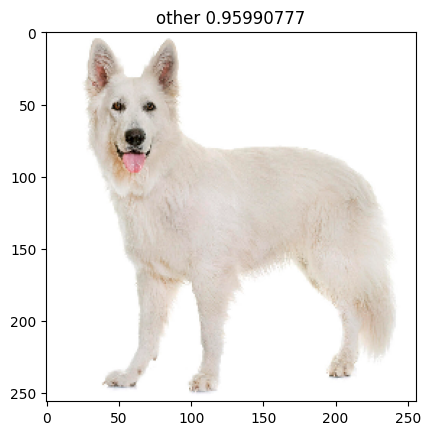

1/1 [==============================] - 0s 309ms/step


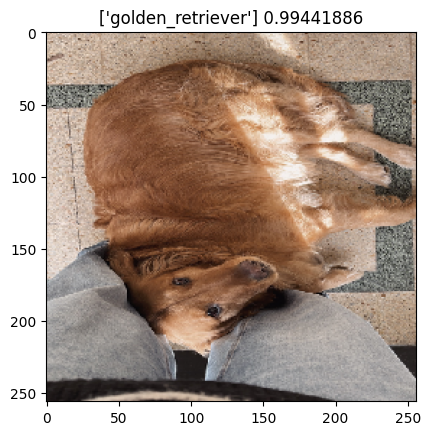

1/1 [==============================] - 0s 313ms/step


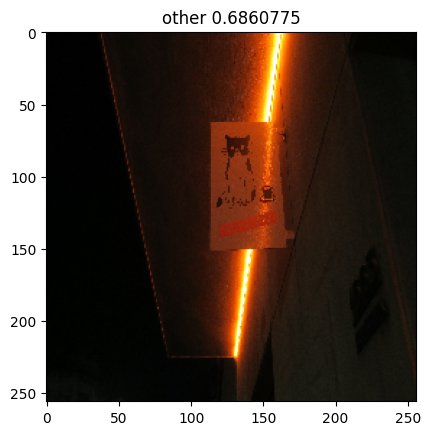

1/1 [==============================] - 0s 307ms/step


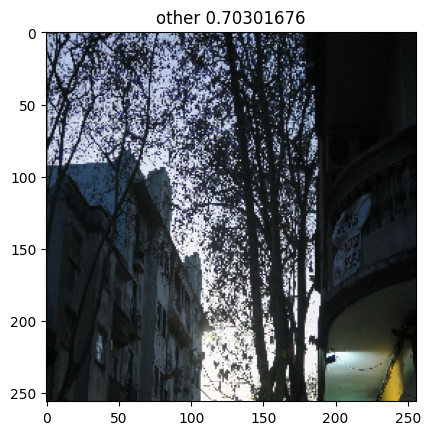

1/1 [==============================] - 0s 384ms/step


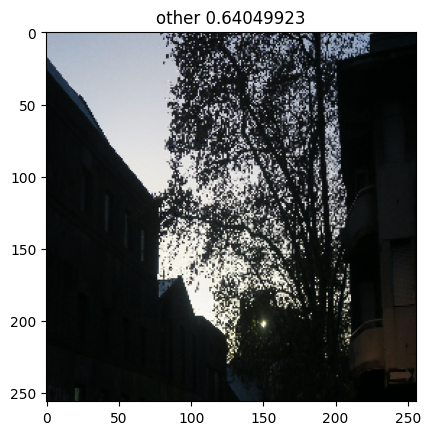

1/1 [==============================] - 0s 293ms/step


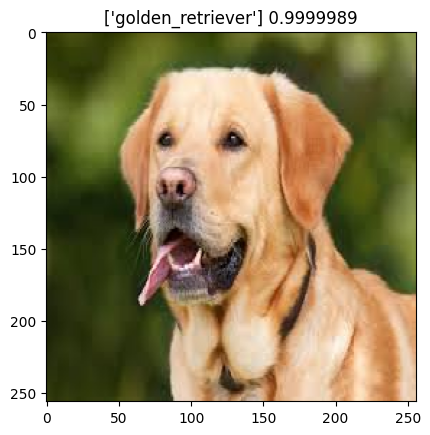

1/1 [==============================] - 0s 307ms/step


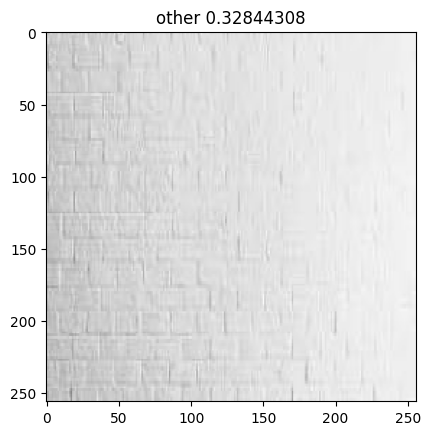

1/1 [==============================] - 0s 410ms/step


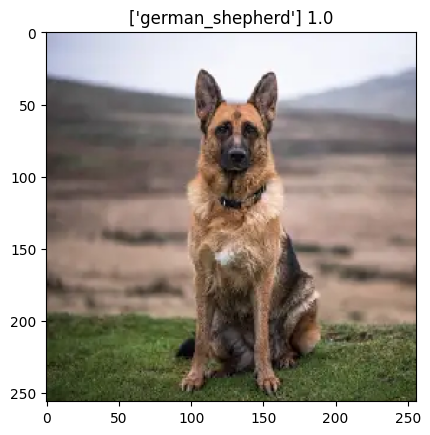

1/1 [==============================] - 0s 326ms/step


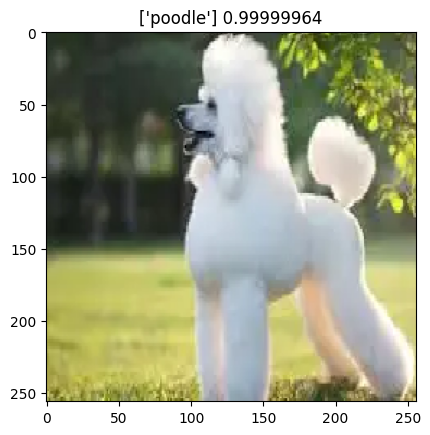

1/1 [==============================] - 0s 440ms/step


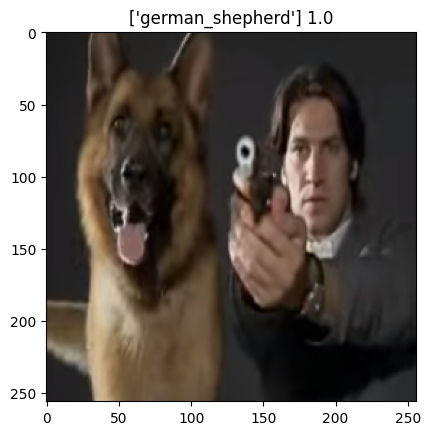

1/1 [==============================] - 0s 409ms/step


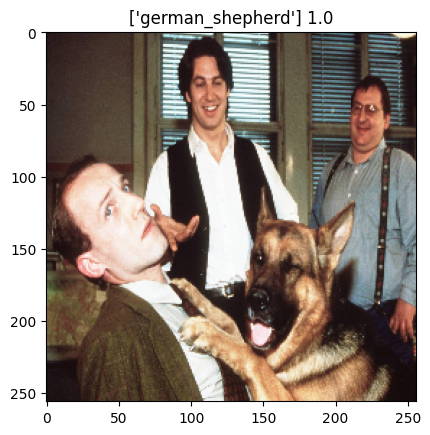

1/1 [==============================] - 0s 396ms/step


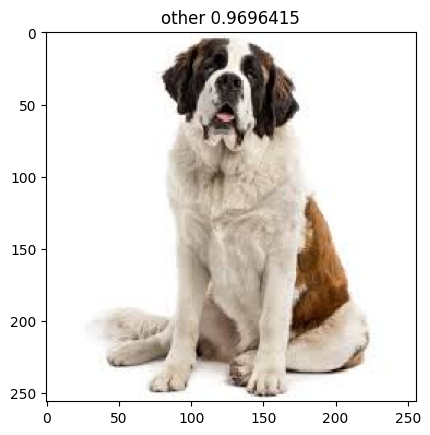

1/1 [==============================] - 0s 367ms/step


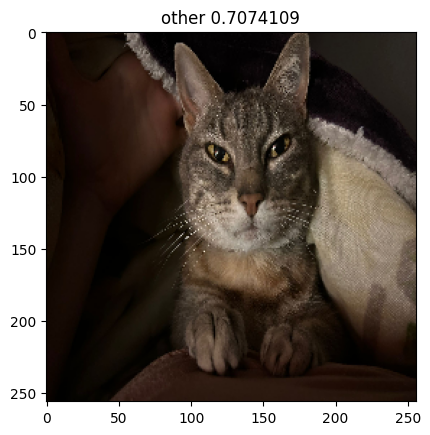

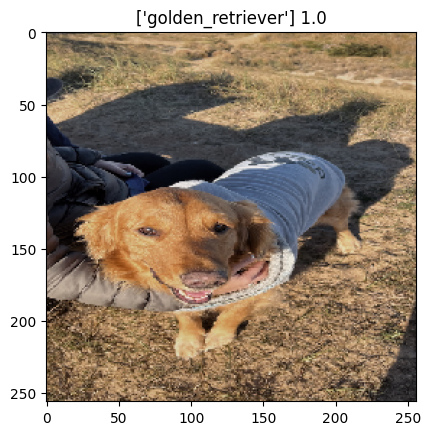

In [14]:
pred=[]
for i in os.listdir('Pruebas'):
    pred,trsust =classifyimg(i,0.97)
    pred.append(pred)

### Alternative 2: Build a Neural Network to Classify as "Other"

A neural network could be created to decide whether an image belongs to one of the 4 existing classes or not. To achieve this, all the dog images we have would be combined into a new training set to create a representative dataset for the "other" class. This network would use Transfer Learning and retrain a model similar to the one used for classification but with a sigmoid output. For this case, a smaller neural network, such as MobileNetV3Small, would likely be used.

Below the suggested model

In [16]:
MobileNet = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

#Se fijan los pesos de resnet y se congelan las capas de la red a excepecion de las que agregamos nosotros para finetuneear el modelo



x = MobileNet.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
output = Dense(units=1, activation='sigmoid')(x)



model = Model(MobileNet.input, output)

MobileNet.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   